## PSD of BaroData

In [1]:
import matplotlib.pyplot as plt
import os

from obspy import UTCDateTime, read, Stream, Trace, read_inventory
# from scipy.signal import welch
# from numpy import log10, zeros, append, linspace, mean, median, array, where, transpose, shape, histogram
# from pandas import DataFrame, concat, Series, date_range, to_pickle, read_csv
# from pathlib import Path
# from andbro__load_FURT_stream import __load_furt_streamn


import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# tbeg, tend = UTCDateTime("2023-09-03"), UTCDateTime("2023-09-07")
tbeg, tend = UTCDateTime("2023-11-01"), UTCDateTime("2023-11-10")

path_to_figs = root_path+"Documents/ROMY/ROMY_infrasound/figures/"

## time of inlet below gravel
t_gravel = UTCDateTime("2023-09-20 12:00")

##
t_gravel_filter = UTCDateTime("2023-10-05 12:00")

##
t_mushroom_filter = UTCDateTime("2023-10-13 16:00")

##
t_mushroom_foam_filter = UTCDateTime("2023-11-09 12:00")

# IROMY DATA

2 Trace(s) in Stream:
BW.FFBI..BDF | 2023-11-01T00:00:00.005000Z - 2023-11-10T00:00:00.005000Z | 40.0 Hz, 31104001 samples
BW.FFBI..BDO | 2023-11-01T00:00:00.005000Z - 2023-11-10T00:00:00.005000Z | 40.0 Hz, 31104001 samples


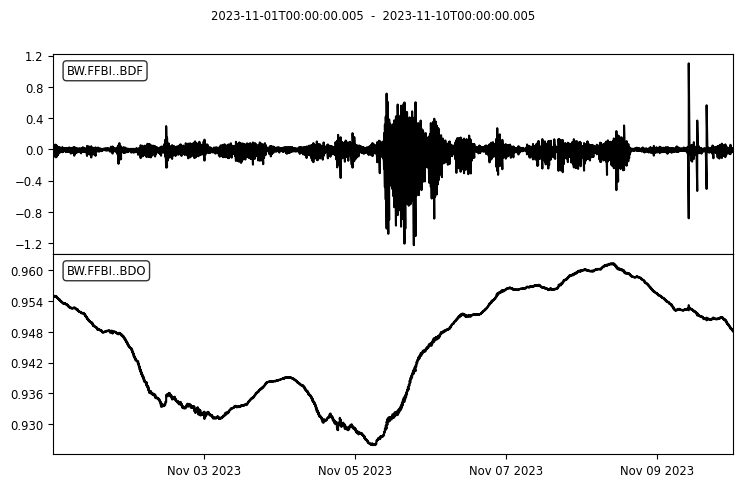

In [4]:
from andbro__read_sds import __read_sds
from obspy import read_inventory

## period to check data... one sided differential signals...
# tbeg, tend = "2023-08-13","2023-08-20"
# ffbi = __read_sds("/import/kilauea-data/LNM2/mb2000/sds/", "BW.IROMY..BD*", tbeg, tend)

ffbi = __read_sds("/bay200/mseed_online/archive/", "BW.FFBI..BD*", tbeg, tend)

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

ffbi = ffbi.remove_sensitivity(ffbi_inv)

## remove gain and sensitivity
# for tr in ffbi:
#     if "DF" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /0.02  # gain=1 sensitivity_reftek=6.28099e5cou/nt/V; sensitivity_mb2005=0.02 VPa
#     elif "DI" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /1e-3  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa
#     elif "DO" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

ffbi.merge()

print(ffbi)

ffbi.plot(equal_scale=False);

## PROMY Data

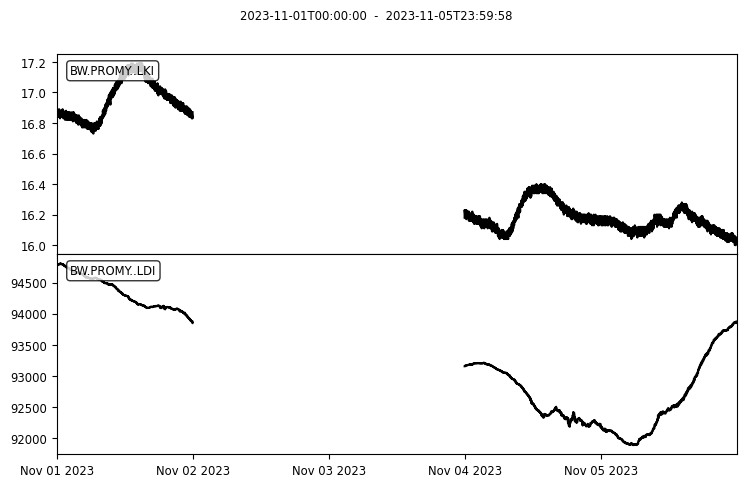

In [5]:
promy = __read_sds(archive_path+"romy_archive/", "BW.PROMY..L*", tbeg, tend)

promy.plot(equal_scale=False);

# FURT Data

In [6]:
from andbro__load_FURT_stream import __load_furt_stream

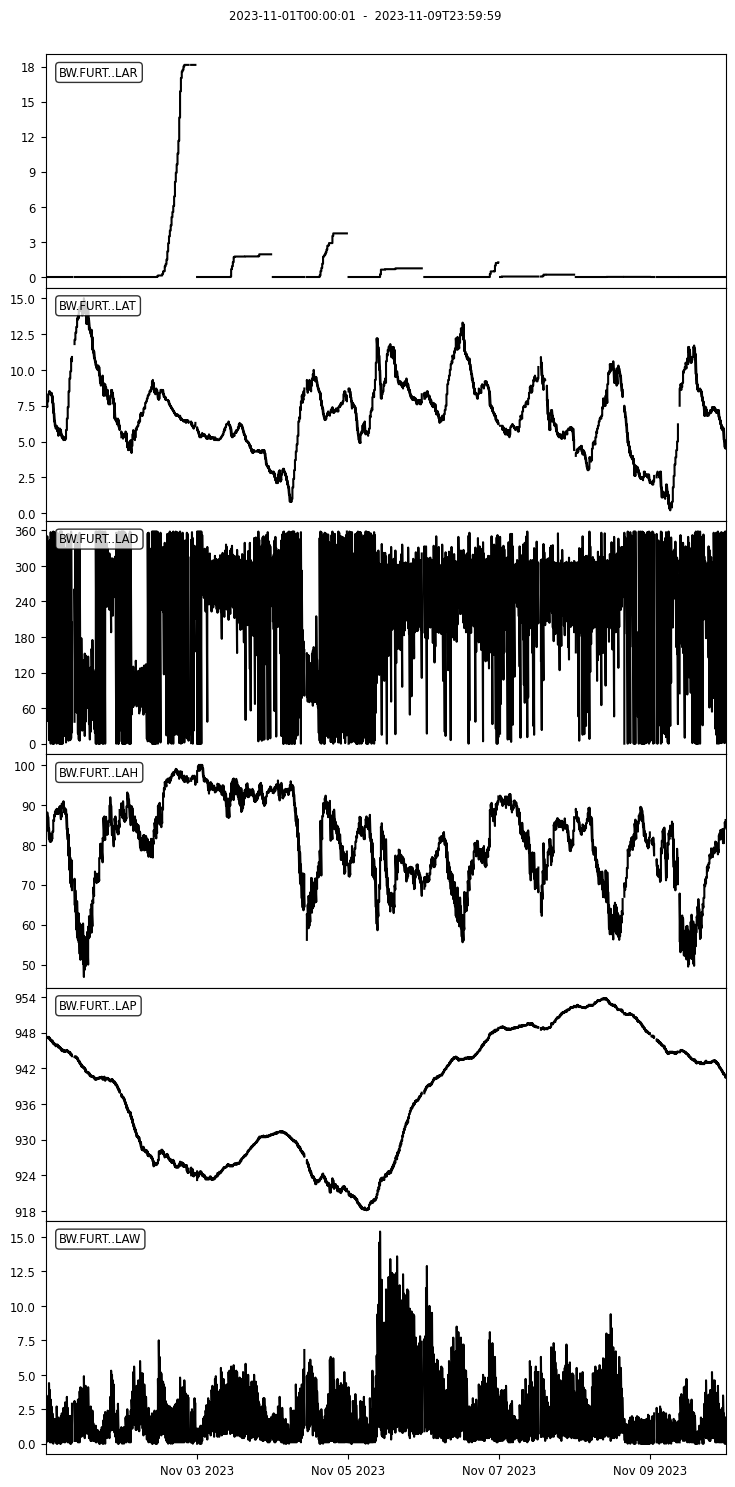

In [7]:
furt = __load_furt_stream(tbeg, tend, show_raw=False, sampling_rate=1.0)
furt.plot(equal_scale=False);

## Plot Data

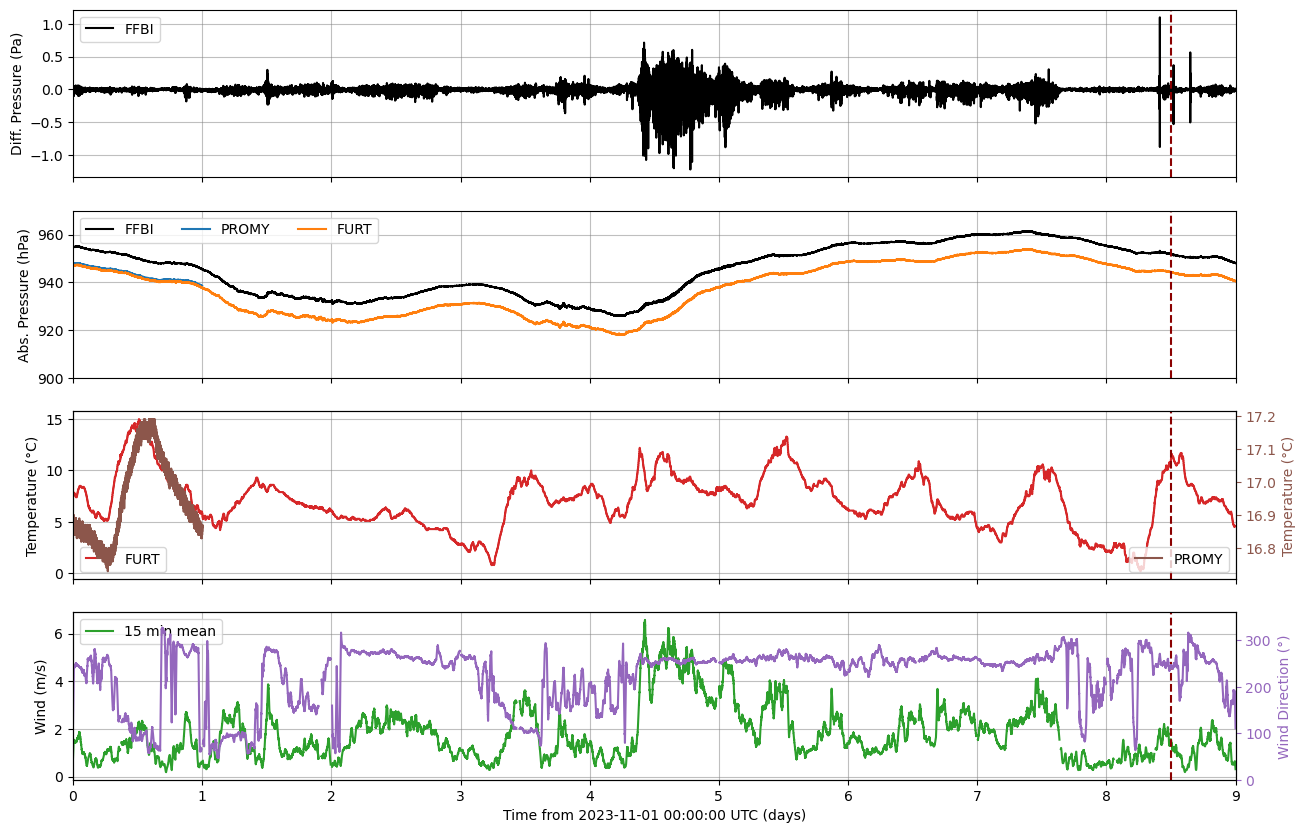

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

def smooth(y, box_pts):
    from numpy import ones, convolve, zeros, array, concatenate
    box = ones(box_pts)/box_pts
    y = concatenate((zeros(box_pts), array(y), zeros(box_pts)))
    y_smooth = convolve(y, box, mode='same')
    return y_smooth[box_pts:-box_pts]


time_scaling = 86400

ax[0].plot(ffbi.select(channel="*F")[0].times()/time_scaling, ffbi.select(channel="*F")[0].data, label="FFBI", color="k")


ax[1].plot(ffbi.select(channel="*O")[0].times()/time_scaling, ffbi.select(channel="*O")[0].data*1000, label="FFBI", color="k")
ax[1].plot(promy.select(channel="LDI")[0].times()/time_scaling, promy.select(channel="LDI")[0].data/100, label="PROMY", color="tab:blue")
ax[1].plot(furt.select(channel="LAP")[0].times()/time_scaling, furt.select(channel="LAP")[0].data, label="FURT", color="tab:orange")


ax[2].plot(furt.select(channel="LAT")[0].times()/time_scaling, furt.select(channel="LAT")[0].data, label="FURT", color="tab:red")
ax22 = ax[2].twinx()
ax22.plot(promy.select(channel="LKI")[0].times()/time_scaling, promy.select(channel="LKI")[0].data, label="PROMY", color="tab:brown")
ax22.legend(loc=4)
ax22.tick_params(axis='y', colors="tab:brown")

wind_force = smooth(furt.select(channel="LAW")[0].data, 900)
ax[3].plot(furt.select(channel="LAW")[0].times()/time_scaling, wind_force, color="tab:green", label="15 min mean")

ax32 = ax[3].twinx()
wind_direction = smooth(furt.select(channel="LAD")[0].data, 900)
ax32.plot(furt.select(channel="LAD")[0].times()/time_scaling, wind_direction, color="tab:purple", label="15 min mean")
ax32.set_ylim(0, 360)
ax32.tick_params(axis='y', colors="tab:purple")


ax22.set_ylabel("Temperature (°C)", color="tab:brown")
ax32.set_ylabel("Wind Direction (°)", color="tab:purple")
ax[0].set_ylabel("Diff. Pressure (Pa)")
ax[1].set_ylabel("Abs. Pressure (hPa)")
ax[2].set_ylabel("Temperature (°C)")
ax[3].set_ylabel("Wind (m/s)")

ax[3].set_xlabel(f"Time from {tbeg.date} {str(tbeg.time).split('.')[0]} UTC (days)")

for i in range(4):
    ax[i].grid(alpha=0.5, color="grey", zorder=0)
    ax[i].legend()
    ax[i].axvline((t_gravel-tbeg)/time_scaling, color="darkblue", ls="--")
    ax[i].axvline((t_mushroom_filter-tbeg)/time_scaling, color="purple", ls="--")
    ax[i].axvline((t_gravel_filter-tbeg)/time_scaling, color="cyan", ls="--")
    ax[i].axvline((t_mushroom_foam_filter-tbeg)/time_scaling, color="darkred", ls="--")

ax[1].legend(ncol=3)

ax[1].set_ylim(900, 970)
ax[3].set_xlim(0, max(ffbi.select(channel="*F")[0].times()/time_scaling))

plt.show();

In [9]:
fig.savefig(path_to_figs+f"comparison_{tbeg.date}_{tend.date}.tiff", dpi=200, format="tiff", bbox_inches='tight')